# Lab 1: image rectification

This lab has two main goals:

1) Get more familiar with the hierarchy of 2D transformation <br>

2) Remove the projective distortion of an image of a planar object (image rectification)

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [4]:
from PIL import Image, ImageDraw
import numpy as np
from scipy.ndimage import map_coordinates
from numpy import linalg as LA
from math import ceil
from utils import line_draw, plot_img

## **1. Applying image transformations**

In this first part of the lab you will apply different types of 2D transformations to a given image. For that, you first need to create a function that applies a homography to animage.

<span style='color:Green'> - Create the function  *apply_H* that gets as input a homography and
an image and returns the image transformed by the homography. </span>

Note: The size of the transformed image has to be automatically set so as to 
contain the whole transformed image.
You will need to interpolate the image values at some points, for that,
you may use the function *scipy.ndimage.map_coordinates*

In [12]:
def apply_H(I, H):
    
    # complete ...
    # for the size of the image
    h,w,n_channels = I.shape
    tl = [0,0,1]
    tr = [0,w,1]
    bl = [h,0,1]
    br = [h,w,1]
    #print("tl is {} and h is {}".format(tl,H))
    tl_h = np.matmul(H,np.transpose(tl))
    tr_h = np.matmul(H,np.transpose(tr))
    bl_h = np.matmul(H,np.transpose(bl))
    br_h = np.matmul(H,np.transpose(br))
    #print(tl_h)
    coords_h = [tl_h, tr_h, bl_h, br_h]
    #print(coords_h)
   
    def _hom_2_cart(coords_h):
        coords_c=[]
        for c in coords_h:
            #print("c is {} and c2 is {}".format(c,c[2]))
            if c[2]==0:
                sys.exit("Dividing by zero error")
            else:
                coords_c.append([int(c[0]/c[2]),int(c[1]/c[2])])
        return coords_c
    
    #print("Coords_h: ", np.asarray(coords_h).shape, coords_h)
    coords_c = np.asarray(_hom_2_cart(coords_h))
    x_max = np.max(coords_c[:,1]) 
    x_min = np.min(coords_c[:,1]) 
    y_max = np.max(coords_c[:,0]) 
    y_min = np.min(coords_c[:,0]) 
    
    w_out = x_max-x_min
    h_out = y_max-y_min
    
    out = np.zeros((h_out, w_out, n_channels))
    
    out_rows = np.arange(h_out)
    out_cols = np.arange(w_out)
    out_coords = np.empty((len(out_rows), len(out_cols), 3))
    out_coords[..., 0] = out_rows[:, None]
    out_coords[..., 1] = out_cols
    out_coords[..., 2] = 1
        
    H_inv = LA.inv(H)
    
    original_coords = out_coords.copy()
    
    for idx_a, a in enumerate(original_coords):
        for idx_b, b in enumerate(a):
            original_coords[idx_a, idx_b] = np.matmul(H_inv,np.transpose(b))
           
    #print(original_coords.shape)
    original_coords = original_coords.reshape(w_out*h_out,3)
    #print("Original Coords: ", original_coords.shape, original_coords)
    original_coords_c = np.asarray(_hom_2_cart(original_coords))
    original_coords_c = original_coords_c.reshape(h_out,w_out,2)
    
    x_coords = original_coords_c[:,:,1].reshape(h_out,w_out)
    y_coords = original_coords_c[:,:,0].reshape(h_out,w_out)
    
    #print(y_coords.shape)
    #print(x_coords.shape)
    
    for i in range(n_channels):
        # Revisar quina de les dues opciones es la correcta
        out[:, :, i] = map_coordinates(I[:,:,i],[y_coords, x_coords], mode='nearest')
        #out[:, :, i] = map_coordinates(I[:,:,i],[x_coords, y_coords], mode='nearest')
    
    #print(out)
    
    return out

### **1.1 Similarities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a similarity transformation. </span>

[[ 0.25452071 -0.43037101  3.        ]
 [ 0.43037101  0.25452071  8.        ]
 [ 0.          0.          1.        ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


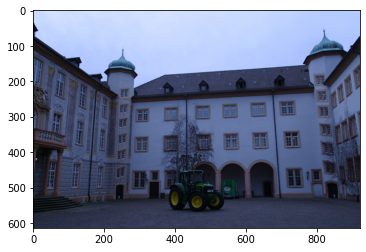

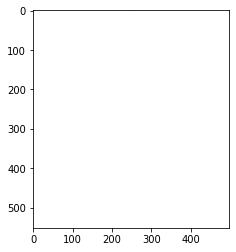

In [13]:
# Format of H in the slides (Lecture 2a)

theta = 0.33*np.pi; # Random angle
R = [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]] #Rotation matrix (https://en.wikipedia.org/wiki/Rotation_matrix)
s = 0.5 # Scaling factor
t = [3, 8] # Translation Vector (random values)

H = [[s*R[0][0],  s*R[0][1],  t[0]], 
     [s*R[1][0],  s*R[1][1],  t[1]], 
     [0,  0,  1]]

print(np.asarray(H))

img_path = "./Data/0000_s.png"
I = Image.open(img_path)
I_sim = apply_H(np.array(I), H)

plot_img(I)
plot_img(I_sim)

### **1.2 Affinities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces an affine transformation.  </span>

<span style='color:Green'> - Decompose the affinity in four transformations: two
rotations, a scale, and a translation (you may use function *numpy.linalg.svd* for that).  </span>

<span style='color:Green'> - Verify that the product of the four previous transformations
produces the same matrix H as above.  </span>

<span style='color:Green'> - verify that the proper sequence of the four previous
transformations over the image I produces the same transformed image as before.  </span>

In [ ]:
#H = ... # complete

I_aff = apply_H(np.array(I), H)

plot_img(I)
plot_img(I_aff)

### **1.3 Projective transformations (Homographies)**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a projective transformation.  </span>

In [ ]:
#H = ... # complete

I_proj = apply_H(np.array(I), H)

plot_img(I)
plot_img(I_proj)

## **2. Affine Rectification**

This step is needed in order to rectify an image in a stratified way, where we first perform affine rectification (current section) and then metric rectification (Section 3).

In [ ]:
# load images and lines
img_path = "./Data/0000_s.png"
I = Image.open(img_path)

lines_path = "./Data/0000_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
i = 423 # line index
p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
p2 = [A[i, 2], A[i, 3], 1] # final point in line i
i = 239
p3 = [A[i, 0], A[i, 1], 1]
p4 = [A[i, 2], A[i, 3], 1]
i = 711
p5 = [A[i, 0], A[i, 1], 1]
p6 = [A[i, 2], A[i, 3], 1]
i = 564
p7 = [A[i, 0], A[i, 1], 1]
p8 = [A[i, 2], A[i, 3], 1]

<span style='color:Green'> - Compute the lines l1, l2, l3, l4, that pass through the different pairs of points.  </span>

In [ ]:
l1, l2, l3, l4 = # complete ...

In [ ]:
# show the chosen lines in the image
canv = ImageDraw.Draw(I)
point_color = (0, 0, 255)
line_draw(l1, canv, I.size)
line_draw(l2, canv, I.size)
line_draw(l3, canv, I.size)
line_draw(l4, canv, I.size)

# The displayed lines will alter image I so we have to reopen the original image after the plot
plot_img(I)
I = Image.open(img_path)

<span style='color:Green'> - Compute the homography that affinely rectifies the image </span>
ToDo: 

<span style='color:Green'> - Compute the transformed lines lr1, lr2, lr3, lr4 and
      show the transformed lines in the transformed image. </span>
      
<span style='color:Green'> - To evaluate the results, compute the angle between the different pair 
      of lines before and after the image transformation. </span>
ToDo: 
**better rephrase more precisely (see two options and also expression of line slope)**    

## **3. Metric Rectification**

### **3.1 Metric rectification after the affine rectification (stratified solution)**

<span style='color:Green'> - Write the code that performs the metric rectification (after the affine rectification). </span>

As qualitative evaluation method you can display the images (before and after the metric rectification) with the chosen lines printed on it.
      
<span style='color:Green'> - Compute the angles between the pair of lines before and after rectification. Comment the result. </span>
      


## **4. Affine and Metric Rectification of the left facade of image 0001**

<span style='color:Green'> - Write the code that rectifies the left facade of image 0001 with
      the stratified method.  </span>
      
Note: For a better visualization of the result crop the initial image so that only the left facade is visible.

<span style='color:Green'> - Show the (properly) transformed lines that are used in every step.  </span>
      
      

## **5. OPTIONAL: Metric Rectification in a single step**

<span style='color:Green'> - Write the code that performs metric rectification in a single step (algorithm pages 55-57, Hartley-Zisserman book). </span>

Note: Use 5 pairs of orthogonal lines. You may consider that windows are square.